### Training the resnet model

In [ ]:
#to view image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

In [ ]:
#old normalizing stuff
def mean_std(loader):
    mean = 0
    std = 0
    total = 0
    for images, _ in loader:
        image_count = images.size(0)
        images = images.view(image_count, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total += image_count
    mean /= total
    std /= total
    return mean, std

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
mean = [0.0393, 0.0359, 0.0521]
std = [1.0152, 1.0218, 1.0202]

In [ ]:

mean = [0.0393, 0.0359, 0.0521]
std = [1.0152, 1.0218, 1.0202]
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])
train_dataset = ImageFolder('/content/drive/MyDrive/train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory = True)
test = ImageFolder('/content/drive/MyDrive/test', transform=transform)
test_loader = torch.utils.data.DataLoader(test, batch_size=16, shuffle=True, pin_memory = True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setting up resnet model

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

resnet = models.resnet18(True)
num_ftrs = resnet.fc.in_features
number_of_classes = 1
resnet.fc = nn.Linear(num_ftrs, number_of_classes)
resnet.sigmoid = nn.Sigmoid()
# resnet = resnet.to('cuda')
criterion = nn.BCELoss()
#momentum accelarates SGD finding
#weight_decay prevents overfitting
# optimizer = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001, weight_decay=0.003)


In [ ]:
def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
def save_checkpoint(model, epoch, opt, best_acc):
    state = {
        'epoch': epoch +1,
        'model': model.state_dict(),
        'best acc': best_acc,
        'optimizer': opt.state_dict(),
    }
    torch.save(state, 'model_best_checkpoint.pth.tar')

In [ ]:
import torch.nn.functional as F

def eval_model_on_test(loader):    
    resnet.eval().cuda()
    r_correct = 0
    total = 0
    device = get_default_device()
    with torch.no_grad():
        for inputs, labels in loader:
            # Move the inputs and labels to the device (CPU or GPU)
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(dim=1)
            
            total += labels.size(0)
                        
            # Forward pass
            outputs = resnet(inputs)
            # Apply sigmoid function to the output tensor
            r_correct += (((torch.sigmoid(outputs) > 0.5) * 1.0) == labels).sum()
    epoch_acc = r_correct.item()/len(loader.dataset)
    print (f"Test Accuracy: {epoch_acc}")
    return epoch_acc

In [ ]:
# Train the model on your data
device = get_default_device()
print(device)
best_acc = 0
resnet.cuda()
for epoch in range(100):
    print(f'Epoch number {epoch}')
    resnet.train()
    r_loss = 0.0
    r_correct = 0.0
    total = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(dim=1)
        # labels = labels.to(device).view(oldLabels.shape[0], 1)
        total += labels.size(0)
        optimizer.zero_grad()

        outputs = resnet(images)

        sigmoid_outputs = torch.sigmoid(outputs)
        loss = criterion(sigmoid_outputs, labels.float())
        loss.backward()
        optimizer.step()
        r_loss += loss.item()
        r_correct += (((sigmoid_outputs > 0.5) * 1.0) == labels).sum()
    epoch_loss = r_loss/len(train_loader)
    print (f"Training Accuracy: {r_correct/len(train_loader.dataset)}")
    
    test_accuracy = eval_model_on_test(test_loader)
    if test_accuracy > best_acc:
        best_acc = test_accuracy
        save_checkpoint(resnet, epoch, optimizer, best_acc)

### Start from here to load previously saved model

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F

checkpoint = torch.load('/model_best_checkpoint.pth.tar')
resnet = models.resnet18(False).cuda()
num_ftrs = resnet.fc.in_features
number_of_classes = 1
resnet.fc = nn.Linear(num_ftrs, number_of_classes)
resnet.sigmoid = nn.Sigmoid()
criterion = nn.BCELoss()
resnet.load_state_dict(checkpoint['model'])
# optimizer = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.01, weight_decay=0.01)
print(checkpoint['best acc'])

ModuleNotFoundError: No module named 'torch'

In [ ]:
# import sys
# sys.path.append('/content/drive/MyDrive') # add path to file directory for colab

from sobol_attribution_method.torch_explainer import SobolAttributionMethod

In [ ]:
import PIL.Image as Image
def classify(model, image_path):
    image_transforms = transforms.Compose([transforms.Resize((256, 256)),
            transforms.ToTensor(), 
            transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])
    model = model.eval().cuda()
    image = Image.open(image_path)
    image = image_transforms(image).float()
    image = image.unsqueeze(0).cuda()
    output = model(image)
    _, pred = torch.max(output.data, 1)
    prob = F.sigmoid(output.data)
    # prob = torch.mean(torch.sigmoid(output.data))
    # return prob[0][0].item()
    if prob[0][0].item()>0.5: 
        return f'red with {prob[0][0].item()}\n'
    else: 
        return f'not red with {1-prob[0][0].item()}\n'

0.065367691218853
0.00823854748159647
0.10118366032838821
0.02659044787287712
0.020048838108778
0.005900696851313114


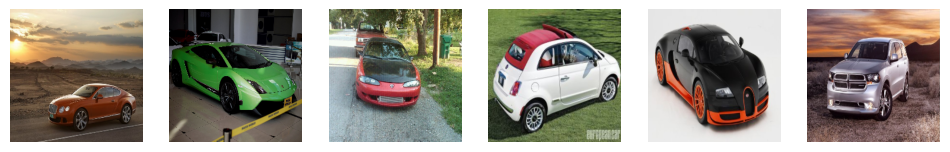

In [ ]:
import cv2
import numpy as np
import scipy

import torch
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
def load_image(path, size=224):
  img = cv2.resize(cv2.imread(path)[...,::-1], (size, size)) / 255.0
  img = np.moveaxis(img, -1, 0).astype(np.float32)
  return img

def show(img, **kwargs):
  if torch.is_tensor(img):
    img = img.detach().cpu().numpy()
    img = np.moveaxis(img, 0, -1)
  
  img -= img.min(); img /= img.max()
  plt.imshow(img, **kwargs)
  plt.axis('off')

images_classes = [
                  ('/content/drive/MyDrive/test/red/00551.jpg', 0),
                  ('/content/drive/MyDrive/test/non-red/03075.jpg', 0),
                  ('/content/drive/MyDrive/test/non-red/02831.jpg', 0),
                  ('/content/drive/MyDrive/test/non-red/01886.jpg', 0),
                  ('/content/drive/MyDrive/test/non-red/01381.jpg', 0),
                  ('/content/drive/MyDrive/test/non-red/03039.jpg', 0),
                  # ('test/non-red/02370.jpg', 0),
                  # ('test/non-red/00453.jpg', 0),
                  # ('test/non-red/03036.jpg', 0),
                  # ('test/non-red/01886.jpg', 0),


]
print(classify(resnet, images_classes[0][0]))
print(classify(resnet, images_classes[1][0]))
print(classify(resnet, images_classes[2][0]))
print(classify(resnet, images_classes[3][0]))
print(classify(resnet, images_classes[4][0]))
print(classify(resnet, images_classes[5][0]))
# print(classify(resnet, 'test/non-red/02370.jpg'))
# print(classify(resnet, 'test/non-red/00453.jpg'))
# print(classify(resnet, 'test/non-red/03036.jpg'))
# print(classify(resnet, 'test/non-red/01886.jpg'))




x = torch.Tensor(np.array([load_image(p) for p, y in images_classes])).cuda()
y = np.array([y for p, y in images_classes])

plt.rcParams["figure.figsize"] = [12, 8]
for i in range(len(x)):
  plt.subplot(1, len(x), i+1)
  show(x[i])
plt.show()
# for i in range(len(x)//2, len(x)):
#   plt.subplot(1, len(x), i+1)
#   show(x[i])
# plt.show()


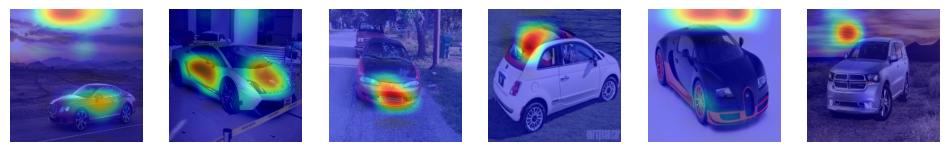

In [ ]:
explainer = SobolAttributionMethod(resnet, grid_size=8, nb_design=32, batch_size=128)
explanations = explainer(x, y)

for i in range(len(x)):
  plt.subplot(1, len(x), i+1)
  show(x[i])
  show(explanations[i], cmap='jet', alpha=0.5)
plt.show()

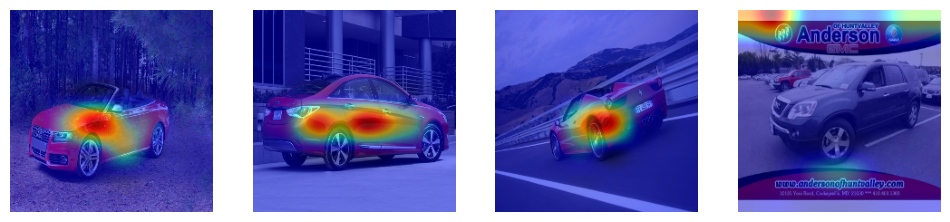

In [ ]:
explainer = SobolAttributionMethod(resnet, grid_size=8, nb_design=32, batch_size=128)
explanations = explainer(x, y)

for i in range(len(x)):
  plt.subplot(1, len(x), i+1)
  show(x[i])
  show(explanations[i], cmap='jet', alpha=0.5)
plt.show()